In [1]:
import pickle 
import re
import numpy as np
with open('Pickle_Files/user_dict_train.pickle', 'rb') as handle:
    user_dict_train = pickle.load(handle)
with open('Pickle_Files/user_dict_test.pickle', 'rb') as handle1:
    user_dict_test = pickle.load(handle1)
with open('Pickle_Files/user_dict_total.pickle', 'rb') as handle2:
    user_dict_total = pickle.load(handle2)
#loading dist_user
dist_user=np.loadtxt('dist_user').view(float)
print(len(dist_user))
with open ('Pickle_Files/user_filepaths', 'rb') as fp:
    filepaths = pickle.load(fp)
print(len(filepaths))
users=[re.sub(r'\.txt$','',filename) for filename in filepaths]
print(users[0:9])


705
705
['100306237', '1005383936', '1009689475', '1017189240', '104048643', '1049020446', '1050455592', '105498404', '1057244852']


In [2]:
targets=["Atheism","Legalization of Abortion","Climate Change is a Real Concern","Feminist Movement","Hillary Clinton"]

In [3]:
target=targets[0]

In [4]:
def get_user_target_info(target): 
    output=[]
    users_target=[]
    users_target_ind=[]
    target_fav=[]
    target_fav_ind=[]
    target_ag=[]
    target_ag_ind=[]
    target_score=[]
    target_col=[]

    for user in users:
        if user!="-":
            if user_dict_total[user][target]!=[]:
                users_target.append(user)
                users_target_ind.append(users.index(user))
                count_f=0
                count_a=0
                for element in user_dict_total[user][target]:
                   
                    if element=="FAVOR" and count_f==0:
                        target_fav.append(user)
                        target_fav_ind.append(users.index(user))
                        count_f=count_f+1
                    if element=="AGAINST" and count_a==0:
                        target_ag.append(user)
                        target_ag_ind.append(users.index(user))
                        count_a=count_a+1
                target_score.append(count_f-count_a)
    for score in target_score:
        if score>0:
            target_col.append('g')
        if score==0:
            target_col.append('y')
        if score<0:
            target_col.append('r')
    elements=[users_target,users_target_ind,target_fav,target_fav_ind,target_ag,target_ag_ind,target_score,target_col]
    for item in elements:
        output.append(item)
    return output

In [5]:
knn_filepaths=[]
for targ in targets: 
    knn_filepaths.append('Pickle_Files/'+targ+'_knn')

In [6]:
from sklearn.neighbors import NearestNeighbors
import pickle 
from collections import defaultdict
output=get_user_target_info(target)
users_target=output[0]
users_target_ind=output[1]
target_fav=output[2]
target_fav_ind=output[3]
target_ag=output[4]
target_ag_ind=output[5]
target_score=output[6]
target_col=output[7]

dist_target=dist_user[users_target_ind][:,users_target_ind]
#to create knn model 
neigh = NearestNeighbors(metric='precomputed')
neigh.fit(dist_target)
filename=knn_filepaths[targets.index(target)]
pickle.dump(neigh, open(filename, 'wb'))
 
"""# load the model from disk
filename=knn_filepaths(targets.index(target))
neigh = pickle.load(open(filename, 'rb'))"""

color_dict={}
color_dict['r']='Against'
color_dict['g']='Favor'
color_dict['y']='None'
from collections import Counter
target_col_stance=[]
for i in range(len(target_col)):
    target_col_stance.append(color_dict[target_col[i]])
#C=dict(Counter(ath_col))
C=dict(Counter(target_col_stance))
L=len(target_col)
class_weight=np.zeros(L)
for i in range(L):
    #class_weight[i]=1/C[ath_col[i]]
    class_weight[i]=1/C[target_col_stance[i]]
    
nn=neigh.kneighbors(dist_target,return_distance=False)
neigh.kneighbors_graph()

target_colarr=np.asarray(target_col)
contingency_dict={}

contingency_dict['Against']=defaultdict(int)
contingency_dict['Favor']=defaultdict(int)
contingency_dict['None']=defaultdict(int)

alpha=1/2
for i in range(L):
    nn_c_dict=dict(Counter((target_colarr[nn[i].tolist()]).tolist()))
    nn_c_dict[target_col[i]]-=1
    for k in nn_c_dict:
        nn_c_dict[k]=nn_c_dict[k]/C[color_dict[k]]**alpha #### Bad practice
    if contingency_dict[color_dict[target_col[i]]][color_dict[max(nn_c_dict, key=nn_c_dict.get)]] is None:
        contingency_dict[color_dict[target_col[i]]][color_dict[max(nn_c_dict, key=nn_c_dict.get)]]=0
    contingency_dict[color_dict[target_col[i]]][color_dict[max(nn_c_dict, key=nn_c_dict.get)]]+=1
print(C)
contingency_dict 


{'Against': 114, 'None': 26, 'Favor': 16}


{'Against': defaultdict(int, {'Against': 89, 'Favor': 15, 'None': 10}),
 'Favor': defaultdict(int, {'Against': 7, 'Favor': 5, 'None': 4}),
 'None': defaultdict(int, {'Against': 7, 'Favor': 10, 'None': 9})}

In [7]:
import numpy as np
# for frequncy vectors
def entropy1(freq1):
    N=np.sum(freq1)
    if N==0:
        return float('NaN')
    else:
        H=0
        for f in freq1:
            if f!=0:
                p=f/N
                H=H-p*np.log2(p)
        return H 

# Entropy of joint distribution from contingency tables
def entropy2(freq):
    N=np.sum(np.sum(freq))
    if N==0:
        return float('NaN')
    else:
        H=0
        for frow in freq:
            for f in frow:
                if f!=0:
                    p=f/N
                    H=H-p*np.log2(p)
        return H 
                
# Mutual Information for contingency tables
def mutual_info(freq): 
    freq0=np.sum(freq,axis=0)
    freq1=np.sum(freq,axis=1)
    return entropy1(freq0)+entropy1(freq1)-entropy2(freq)

# Mutual Information for contingency tables, normalized by entropy
def norm_mutual_info(freq): 
    freq0=np.sum(freq,axis=0)
    freq1=np.sum(freq,axis=1)
    return mutual_info(freq)/np.sqrt(entropy1(freq0)*entropy1(freq1))

freq_test=np.array([[0.0,1.0,0.0],[4.0,53.0,9.0],[4.0,11.0,4.0]])
#freq_test=np.zeros((3,3))+1
#print(np.sum(freq_test))
print(norm_mutual_info(freq_test))


0.0448973187648


In [8]:
#atheism avg neighbor
import numpy as np
class_target=[]
for col in target_col: 
    if col=='r':
        class_target.append(-1)
    if col=='y':
        class_target.append(0)
    if col=='g':
        class_target.append(1)
class_target=np.asarray(class_target)
avg_neighw=[]
count=0

for neighbor in nn: 
    sum=0
    sumw=0
    print(neighbor[1:])
    for element in neighbor[1:]: 
        sum+=class_target[element]*class_weight[element]
        sumw+=class_weight[element]
    avg_neighw.append(sum/sumw)
avw_subset=[]
count+=1
"""for user in rand_users:
    avw_subset.append(avg_neighw[user])"""
userid_target=[]
for ind in users_target_ind: 
    userid_target.append(filepaths[ind])

[ 38 141   7 149]
[146  51  62  60]
[ 75 125 103 155]
[42 41 40 97]
[ 51  15 139  62]
[ 75  57 155 147]
[ 92  74 145 132]
[ 91 141 120   0]
[42  3 35 77]
[141 135 113  38]
[ 45  49 105  30]
[127 138 108  95]
[126 123 114  95]
[69 66 68 73]
[141  38   9  72]
[ 79  80  39 142]
[ 72 124  94  91]
[154 144  92 101]
[115  95  97  67]
[ 40 126 137 100]
[ 74 145  39 132]
[151 119 128 108]
[ 74 154  92 101]
[ 29 132 145 144]
[ 99  36 147  34]
[104  82 138  71]
[153  49 149 116]
[102   9   3 113]
[ 97 127 111  42]
[132  23 145  81]
[ 95 119 108  67]
[ 43 110 117  86]
[ 74  59 142 101]
[ 93 150  34  57]
[85 33 43 54]
[42 63 41  8]
[125 100  19  52]
[139  20 142  39]
[ 14  63 117   9]
[142  59 136  88]
[19 96 97 67]
[ 42  72 135  84]
[ 41   3 135  72]
[117  93  86  31]
[144  73  58 134]
[ 96  76  10 137]
[139 112  79  84]
[135 140  56 102]
[108 114 151  60]
[ 10  26 105 149]
[ 87  52  46 139]
[146  62 114  60]
[ 89 128 123  76]
[130  70 147  99]
[ 34  33 107  43]
[147 107  34  48]
[154 101  65 140

In [9]:
#saving pickle of avg_neigh 
"""import pickle
pickle.dump(avg_neighw, open('Pickle_Files/avg_neighw'+'target', 'wb'))
#loading pickle model 
avg_neighw=pickle.load(open('Pickle_Files/avg_neighw'+'target', 'rb'))"""

"import pickle\npickle.dump(avg_neighw, open('Pickle_Files/avg_neighw'+'target', 'wb'))\n#loading pickle model \navg_neighw=pickle.load(open('Pickle_Files/avg_neighw'+'target', 'rb'))"

In [10]:
#The Remaning Portion is Ahteism Specific 

In [11]:
#Scoring Process 
#randomly generating users to analyze 
sorted_ath_ind=np.argsort(avg_neighw)
if target==targets[0]:
    users_ath_ind=users_target_ind
    userid_ath=userid_target
    rand_users=np.random.choice(156,10)
    print(rand_users)
    avw_subset=[]
    ath_subset_class=[]
    rand_userid=[]
    for user in rand_users:
        rand_userid.append(filepaths[users_ath_ind[user]])
    print(rand_userid)

[  0  35 110 102  41 107  88  27   3  31]
['100306237.txt', '1870184766.txt', '384316868.txt', '35814494.txt', '223185716.txt', '38104249.txt', '3266810329.txt', '1642402514.txt', '1049020446.txt', '17362917.txt']


In [12]:
"""Atheism People that I am rating: ['171561479.txt','3266889440.txt','2738526278.txt','1417728643.txt','734859698.txt','412558070.txt','1088909654.txt','3308568165.txt','1489300873.txt','26350601.txt','51794810.txt', '1870184766.txt', '712746949.txt', '462114432.txt', '219317380.txt', '26350601.txt', '36005781.txt', '442194176.txt', '919886574.txt', '377775232.txt','60935743.txt', '46870227.txt', '626067666.txt', '1683575401.txt', '2834570816.txt', '2563726591.txt', '82881276.txt', '2269197391.txt', '564060928.txt', '233150076.txt','2269197391.txt', '61321567.txt', '3273319902.txt', '47104135.txt', '38308265.txt', '2563726591.txt', '497964337.txt', '3004439539.txt', '159302754.txt', '412558070.txt','3266810329.txt', '297943941.txt', '468379383.txt', '1624769948.txt', '15726358.txt', '38308265.txt', '497964337.txt', '348812932.txt', '60935743.txt', '355470606.txt','2971467125.txt','3363611549.txt','574998716.txt','81127761.txt','933647382.txt','1597398924.txt','2889484097.txt']"""

"Atheism People that I am rating: ['171561479.txt','3266889440.txt','2738526278.txt','1417728643.txt','734859698.txt','412558070.txt','1088909654.txt','3308568165.txt','1489300873.txt','26350601.txt','51794810.txt', '1870184766.txt', '712746949.txt', '462114432.txt', '219317380.txt', '26350601.txt', '36005781.txt', '442194176.txt', '919886574.txt', '377775232.txt','60935743.txt', '46870227.txt', '626067666.txt', '1683575401.txt', '2834570816.txt', '2563726591.txt', '82881276.txt', '2269197391.txt', '564060928.txt', '233150076.txt','2269197391.txt', '61321567.txt', '3273319902.txt', '47104135.txt', '38308265.txt', '2563726591.txt', '497964337.txt', '3004439539.txt', '159302754.txt', '412558070.txt','3266810329.txt', '297943941.txt', '468379383.txt', '1624769948.txt', '15726358.txt', '38308265.txt', '497964337.txt', '348812932.txt', '60935743.txt', '355470606.txt','2971467125.txt','3363611549.txt','574998716.txt','81127761.txt','933647382.txt','1597398924.txt','2889484097.txt']"

In [13]:
#reading the contents of a user 
from pathlib import Path
print(Path('../RBMUsers/'+userid_ath[6]).read_text())


How beautiful on the mountains are the feet of those who bring good news -  https://t.co/fnETAnBKt1May you experience increase as you send your Thanksgiving offering online via https://t.co/yZ3z3TnsZ2🙏 "My Father, My Father, as I praise You and clap my hands, command the Earth to yield her increase to me, my family, my church." 🙏 #Amen🎹🎹 "I have a Father..." 🎹🎹 #SongsOfDeliverance🙏 "My Father, My Father, as I praise You and clap my hands, command the demons of poverty, delay and barrenness to flee." 🙏 #Amen...struggles of your father's house." #Amen #Thanksgiving@leke_sanusi "As you praise God, He will send you destiny helpers, angels like men, men like angels. You'll be raised from poverty and the..Lavish praise opens doors.(1 Sam. 18:2)
“You will leave the bush. You will never be a candidate for the desert. Men will raise you up.”#Amen@leke_sanusi "I command your well of well-being and wealth to spring up." #Amen"Praising God always brings addition and increase." (Acts 2:47)"May your

In [14]:
"""selected_users=[]
selected_ratings=[]
selected_neigh_subset=[]
selected_class=[]"""
selected_ratings=[3, 4, 2, 3, 3, 3, 1, 1, 1, 3,1, 1, 1, 1, 5, 3, 5, 2, 2, 1,1,3,1,1,1,2,5,1,1,1,1,3,2,1,2,2,2,1,1,3,1,3,2,1,1,2,2,2,1,4,2,4,5,3,2,3,5]
selected_users=[30, 89, 56, 13, 146, 114, 5, 92, 17, 53,132,  35, 145, 121,  40,  53, 103, 119, 151, 106,139,123,142,29,61,50,150,42,135,44,42,140 ,91,124,108 ,50,128,73,23,114, 88, 71,122 ,25 ,22,108,128, 98,139, 99,69, 97, 138, 149, 153, 24, 63]
selected_neigh_subset=[]
#selected_users.append(rand_users)
print(len(selected_users))
#selected_ratings.append(ath_ratings)
print(len(selected_ratings))
for user in selected_users: 
    selected_neigh_subset.append(avg_neighw[user])
print(len(selected_neigh_subset))
#selected_neigh_subset.append(avw_subset)
#selected_class+=ath_subset_class

57
57
57


[3, 4, 2, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 5, 3, 5, 2, 2, 1, 1, 3, 1, 1, 1, 2, 5, 1, 1, 1, 1, 3, 2, 1, 2, 2, 2, 1, 1, 3, 1, 3, 2, 1, 1, 2, 2, 2, 1, 4, 2, 4, 5, 3, 2, 3, 5]
[-1.0, 0.61904761904761907, -1.0, -1.0, 0.40740740740740744, -0.40625, 0.67482859941234086, -1.0, -1.0, 0.82978723404255317, -1.0, -0.40625, -1.0, -1.0, 0.37935943060498223, 0.82978723404255317, 0.37935943060498223, -1.0, -1.0, -1.0, -1.0, 0.82978723404255317, -1.0, -1.0, 0.40740740740740744, -1.0, 0.67482859941234086, -0.40625, -0.40625, -1.0, -0.40625, -1.0, -0.40625, -0.40625, -0.40625, -1.0, 0.37935943060498223, -1.0, -1.0, -0.40625, -1.0, 0.0, 0.40740740740740744, -1.0, -1.0, -0.40625, 0.37935943060498223, -0.40625, -1.0, 0.37935943060498223, -1.0, -1.0, 0.37935943060498223, -0.070652173913043473, 0.36254980079681276, 0.67482859941234086, 0.0]


<IPython.core.display.Javascript object>


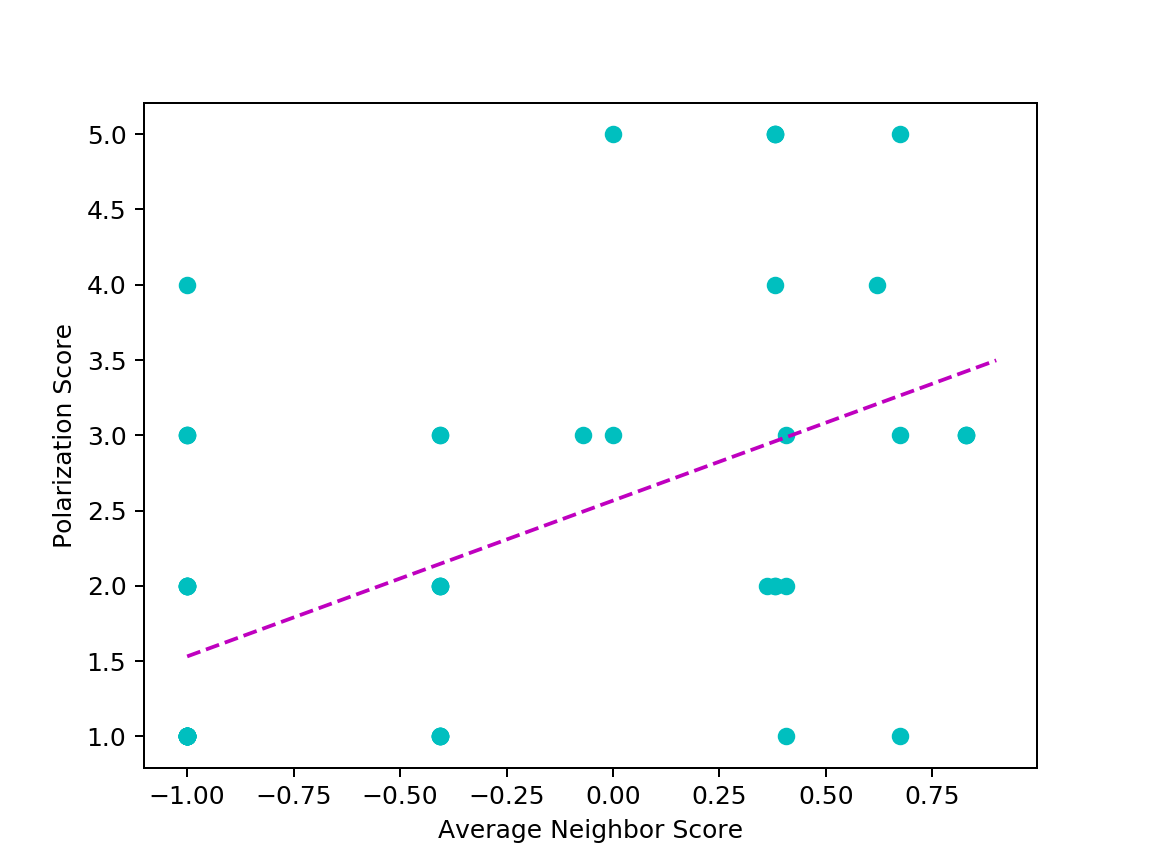

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
print(selected_ratings)
print(selected_neigh_subset)
plt.scatter(selected_neigh_subset,selected_ratings,color='c')
plt.show()
np.corrcoef(selected_ratings,selected_neigh_subset)
m,b=np.polyfit(selected_neigh_subset,selected_ratings,1)
neigh_grid=.1*np.arange(-10,10)
yval=m*neigh_grid+b
plt.plot(neigh_grid,yval,'m--')
#plt.title('Polarization: Manual Score vs. Computational Score')
plt.ylabel('Polarization Score')
plt.xlabel('Average Neighbor Score')


In [16]:
from scipy.stats import pearsonr
pearsonr(selected_neigh_subset,selected_ratings)

(0.5444566576590838, 1.1972051473696728e-05)

In [17]:
#look at elements 46 and 49 of selected_users--they have similar positions and also seem to have similar levels of mixed signals

In [18]:
print(selected_neigh_subset)
print(selected_ratings)
ind=55
print(nn[ind,:])
print(selected_ratings[ind])
print(selected_neigh_subset[ind])

[-1.0, 0.61904761904761907, -1.0, -1.0, 0.40740740740740744, -0.40625, 0.67482859941234086, -1.0, -1.0, 0.82978723404255317, -1.0, -0.40625, -1.0, -1.0, 0.37935943060498223, 0.82978723404255317, 0.37935943060498223, -1.0, -1.0, -1.0, -1.0, 0.82978723404255317, -1.0, -1.0, 0.40740740740740744, -1.0, 0.67482859941234086, -0.40625, -0.40625, -1.0, -0.40625, -1.0, -0.40625, -0.40625, -0.40625, -1.0, 0.37935943060498223, -1.0, -1.0, -0.40625, -1.0, 0.0, 0.40740740740740744, -1.0, -1.0, -0.40625, 0.37935943060498223, -0.40625, -1.0, 0.37935943060498223, -1.0, -1.0, 0.37935943060498223, -0.070652173913043473, 0.36254980079681276, 0.67482859941234086, 0.0]
[3, 4, 2, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 5, 3, 5, 2, 2, 1, 1, 3, 1, 1, 1, 2, 5, 1, 1, 1, 1, 3, 2, 1, 2, 2, 2, 1, 1, 3, 1, 3, 2, 1, 1, 2, 2, 2, 1, 4, 2, 4, 5, 3, 2, 3, 5]
[ 55 147 107  34  48]
3
0.674828599412


In [19]:
#reading the contents of a user 
from pathlib import Path
print(Path('../RBMUsers/'+filepaths[users_ath_ind[selected_users[55]]]).read_text())

@TomiLahren @CarlosBeats #MAGA #Islam #ThisIsIslam #IslamIsTheProblem #AmericaFirst #BanIslam #BanSharia https://t.co/4Lf504td83#Dems are #TARDS @PokieManzz &amp; #Sellout #Cowards To #WeThePeople #DemTARDS #DemoKKKRats @Aled @mitchellvii #MAGA 🇺🇸 https://t.co/oiePYGk6qa@Aled @PokieManzz @mitchellvii #MAGA https://t.co/sChOkhW4fo@mitchellvii @paphotog #MAGA #MakeAmericaGreatAgain #BuildTheWall #BringJobsBack @GM Like Your "Daddy!" 👉👉👉👉👉@Ford👈👈👈👈👈 https://t.co/6wGB4WmO7B@BullyUzi @WhiteHouse @BarackObama @POTUS #MAGA https://t.co/LLfCqTnz07@BullyUzi @Guntraband #MAGA 🇺🇸 https://t.co/aTAID84TnRYou're referring to #Traitors Like @NancyPelosi &amp; @SpeakerRyan @mercedesschlapp WHO are both #AntiAmerican #ObamaBots Since Day One! #MAGA https://t.co/rfxmCRP6yJMay be right but he'll also cut off the #Welfare #WireTransfers &amp; put restrictions of such @asjimeneza @SamLuvsULots @realDonaldTrump #MAGA https://t.co/78ae5kfsE1@SamLuvsULots @2AmendRightorg @realDonaldTrump #MAGA #AmericaFirst 
